In [38]:
import numpy as np
from matplotlib import pyplot as plt
import random

np.set_printoptions(suppress=True)

def load_data():
    """
    Requires csv files
    """
    import pandas as pd
    colnames = [n for n in range(785)]
    colnames[0] = "digit"
    train = pd.read_csv("mnist_train.csv", names=colnames, header=None)
    test = pd.read_csv("mnist_test.csv", names=colnames, header=None)
    Y_train = train["digit"].to_numpy()
    X_train = train.drop(['digit'], axis=1).to_numpy()
    Y_test = test["digit"].to_numpy()
    X_test = test.drop(['digit'], axis=1).to_numpy()
    return X_train, Y_train, X_test, Y_test

def _load_data():
    # Download with TensorFlow backend
    from keras.datasets import mnist
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    return X_train, Y_train, X_test, Y_test

### Uncomment to load
# X_train, Y_train, X_test, Y_test = load_data()

In [56]:
class NeuralNetwork:
    
    def __init__(self, layers):
        
        self.layers = layers
        self.weights = [np.random.uniform(-1., 1., size=(x,y))/np.sqrt(x*y)
                        for x, y in zip(layers[:-1], layers[1:])]
        self.losses = []
        self.accuracies = []
    
    def reLU(self, z):
        return np.maximum(z, 0)
    
    def sigmoid(self, z, prime=False):
        s = 1.0 / (1.0 + np.exp(-z))
        if not prime:
            return s
        return s * (1.0 - s)
        
    def LSE(self, x):
        """
        Numericlly stable version of LogSoftMax
        activation function
        https://stackoverflow.com/questions/44081007/logsoftmax-stability
        https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
        """
        c = x.max(axis=1)
        return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))
    
    def softmax(self, x, prime=False):
        exps = np.exp(x - x.max())
        if prime:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
    
    def forward_pass(self, x):
        A, Z = [x], []
        for w in self.weights:
            z = A[-1].dot(w)
            a = self.reLU(z)
            A.append(a), Z.append(z)
        return A, Z
    
    def feed_forward(self, x):
        if x.shape[1] != self.layers[0]:
            x = x.reshape((-1, self.layers[0]))
        
        for w in self.weights:
            z = x.dot(w)
            x = self.reLU(z)
        return x
    
    def backward_pass(self, x, y):
        """
        Messy for now
        """
        # forward pass
        A, Z = self.forward_pass(x)
        LSM = Z[1] - self.LSE(Z[1]).reshape((-1, 1))
        loss = (-y * LSM).mean()
        # x_lsm2 = self.softmax(Z[1])
        
        # normalize output
        D_out = -y/100
        
        # LSM derivative
        D_LSM = D_out - np.exp(LSM)*D_out.sum(axis=1).reshape((-1, 1))
    
        # Layer 2 derivative
        D_l2 = A[1].T.dot(D_LSM)
        Dx_l2 = D_LSM.dot(self.weights[1].T)
        
        # Layer 1 derivative
        Dx_l1 = (A[1] > 0).astype(np.float32) * Dx_l2
        D_l1 = x.T.dot(Dx_l1)

        # dx_l1 = self.sigmoid(x_relu, prime=True) * Dx_l2

        return loss, Z[1], D_l1, D_l2
    
    def accuracy(self, output, y):
        """ 
        Compute the accuracy between output of network
        and the correct result y.
        """
        res = np.argmax(output, axis=1)
        acc = (res == y).mean()
        return acc
    
    def evaluate(self, x, y):
        """
        Evaluate test data by performing forward pass
        on neural network and return mean (score) for which
        network predicts correct result.
        """
        out = self.feed_forward(x)
        return self.accuracy(out, y)
    
    def generate_samples(self, X_train, Y_train, batch_size):
        """
        Generating random samples from training data
        with batch size and pre-processing to fit
        dimensions of nn layers
        """
        samps = np.random.randint(0, X_train.shape[0], size=batch_size)
        X = X_train[samps]
        Y = Y_train[samps]
        
        # Pre-processing...
        X_ = X.reshape((-1, self.layers[0]))
        Y_ = np.zeros((len(Y),10), np.float32)
        Y_[range(Y_.shape[0]), Y] = 1
        
        return X_, Y, Y_
        
    def SGD(self, X_train, Y_train, l_rate=0.001, BS=128, epochs=1000):
        
        for i in range(epochs):
            X, Y, Y_ = self.generate_samples(X_train, Y_train, BS)
            loss, out, D_l1, D_l2 = self.backward_pass(X, Y_)
            acc = self.accuracy(out, Y)

            self.weights[0] = self.weights[0] - l_rate * D_l1
            self.weights[1] = self.weights[1] - l_rate * D_l2

            self.losses.append(loss)
            self.accuracies.append(acc)
            if i % 100 == 0:
                print(f"Loss {loss:0.2f} Accuracy {acc:0.2f}")

In [57]:
n1 = NeuralNetwork([784, 128, 10])
n1.SGD(X_train, Y_train, 0.001, 128, 1000)

Loss 0.24 Accuracy 0.12
Loss 0.04 Accuracy 0.88
Loss 0.02 Accuracy 0.91
Loss 0.02 Accuracy 0.95
Loss 0.03 Accuracy 0.94
Loss 0.01 Accuracy 0.94
Loss 0.01 Accuracy 0.97
Loss 0.01 Accuracy 0.95
Loss 0.01 Accuracy 0.98
Loss 0.02 Accuracy 0.95


Score:  0.9619


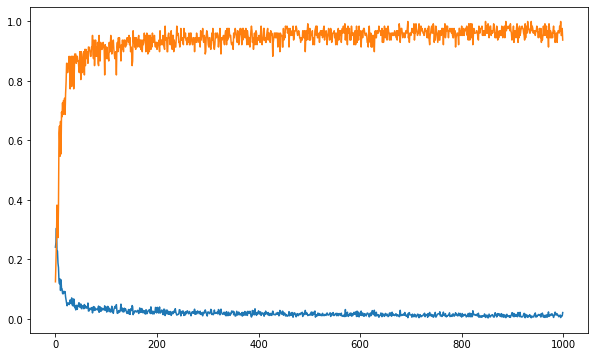

In [58]:
print("Score: ", n1.evaluate(X_test, Y_test))
plt.figure(figsize=(10,6))
plt.plot(n1.losses)
plt.plot(n1.accuracies)

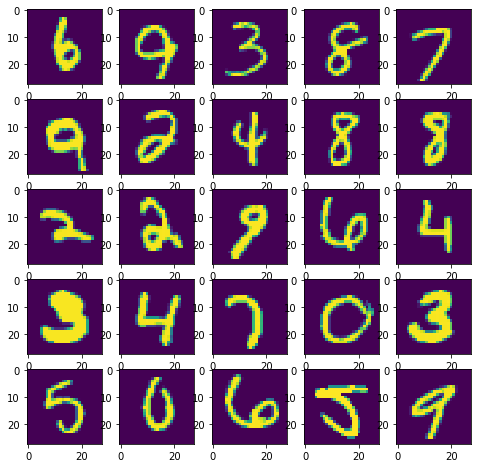

In [54]:
# Random digits
s1, s2 = 5, 5
fig, ax = plt.subplots(s1, s2, figsize=(8,8))
s = ''
for i in range(s1):
    for j in range(s2):
        samp = np.random.randint(0,10000)
        ax[i, j].imshow(X_test[samp].reshape(28,28))
        s += f'{np.argmax(n1.feed_forward(X_test[samp]))}   '
    s += '\n'

In [55]:
# Predictions
print(s)

6   9   3   8   7   
9   2   4   8   8   
2   2   9   6   4   
3   4   7   0   3   
5   0   6   5   9   

